In [1]:
import pandas as pd
import MeCab
import ipadic
import os
import numpy as np
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import re

### text
预处理用的函数

In [3]:
stopwords = []
for stopword_file in os.listdir("stopword"):
    with open(os.path.join("stopword",stopword_file),"r") as fp:
        stopword = [line.replace("\n","") for line in fp.readlines()]
    stopwords += stopword

def lemma(text:list): #1d list
    "日语变成辞书形"
    CHASEN_ARGS = r' -F "%m\t%f[7]\t%f[6]\t%F-[0,1,2,3]\t%f[4]\t%f[5]\n"'
    CHASEN_ARGS += r' -U "%m\t%m\t%m\t%F-[0,1,2,3]\t\t\n"'
    wakati = MeCab.Tagger(ipadic.MECAB_ARGS + CHASEN_ARGS)
    temp_text = "".join(text)
    wakati_text = wakati.parse(temp_text).split("\n")
    dic_t = {}
    for token in wakati_text:
        token = token.split("\t")
        if token[0] != "" and token[0] != "EOS":
            dic_t[token[0]] = token[2]
    for idx in range(len(text)):
        if text[idx] in dic_t:
            text[idx] = dic_t[text[idx]]
    return text #list of lemmalization

def wakati_tolist(text:list, stopword:list=[]): #list of str
    #convert list of str to list of list, removing stopword and \n， and perform lemmalization

    wakati = MeCab.Tagger("-Owakati")
    for line_idx in range(len(text)):
        line = wakati.parse(text[line_idx])
        line = line.replace("\n", "")
        line_list = line.split()
        line_list = [token for token in line_list if token not in stopword] #1d list
        line_list = lemma(line_list)
        text[line_idx] = line_list
    return text #list of list



In [79]:
# data = pd.read_csv("/home/hc/[NII-IDR] 楽天市場データ/sample/sample_from_raw.csv")
# text = data['レビュー内容'].to_list()
# text = wakati_tolist(text,stopword=stopwords)

In [80]:
# data = pd.read_csv("/home/hc/[NII-IDR] 楽天市場データ/sample/sample_from_raw.csv")
# text = data['レビュー内容'].to_list()

# text = wakati_tolist(text,stopword=stopwords)
# id2word = gensim.corpora.Dictionary(text)
# len(id2word)

### Class

In [12]:
from datetime import datetime
class Feature_extractor:

    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)

        self.save_folder = "features"
        self.features = {}

    def date_feature(self):
        dates = self.data["レビュー登録日時"].to_numpy()
        data_format = "%Y-%m-%d %H:%M"
        end_day = datetime.strptime("2019-12-31 23:59",data_format)
        self.features["df"] = [(end_day - datetime.strptime(date,data_format)).days for date in dates]

    def is_title(self):
        self.features["it"] = self.data["レビュータイトル"].isnull().to_numpy().astype(int)

    def is_mokuteki(self):
        self.features["im"] = self.data["目的"].isnull().to_numpy().astype(int)

    def is_ti(self):
        self.features["itsu"] = self.data["使い道"].isnull().to_numpy().astype(int)

    def is_hin(self):
        self.features["ih"] = self.data["頻度"].isnull().to_numpy().astype(int)

    def title_wc(self):
        self.tc = []
        wakati = MeCab.Tagger("-Owakati")
        file_name = "title_count.txt"
        if file_name not in os.listdir(self.save_folder):
            review = self.data["レビュータイトル"].to_numpy()
            for line in tqdm(review):
                if line is np.nan:
                    out = 0
                else:
                    out = len(wakati.parse(line).split())
                self.tc.append(out)
            with open(os.path.join(self.save_folder,file_name), "w") as file:
                for line in self.tc:
                    file.write(str(line))
                    file.write("\n")
        else:
            with open(os.path.join(self.save_folder,file_name), "r") as file:
                self.tc = [int(line.replace("\n", "")) for line in file.readlines()]

        self.features["tc"] = self.tc

    def word_count(self):
        self.wc = []
        wakati = MeCab.Tagger("-Owakati")
        file_name = "word_count.txt"
        if file_name not in os.listdir(self.save_folder):
            with open(os.path.join(self.save_folder,file_name), "w") as file:
                review = self.data["レビュー内容"].to_numpy()
                for line in tqdm(review):
                    out = len(wakati.parse(line).split())
                    file.write(str(out))
                    file.write("\n")
                    self.wc.append(out)
        else:
            with open(os.path.join(self.save_folder,file_name), "r") as file:
                self.wc = [int(line.replace("\n", "")) for line in file.readlines()]

        self.features["wc"] = self.wc

    def score(self):
        self.features['score'] = self.data["評価ポイント"].to_numpy()
        # self.features['score'] = s(self.data['評価ポイント'] == 1).astype(int).to_numpy()
    def encode_mokuteki(self):
        return pd.get_dummies(self.data["目的"]).astype(int)

    def encode_hindo(self):
        return pd.get_dummies(self.data["頻度"]).astype(int)

    def encode_tsu(self):
        return pd.get_dummies(self.data["使い道"]).astype(int)

    def encode_denpou(self):
        # cate = self.data["店舗名"].to_frame()
        # le = LabelEncoder()
        # a = le.fit_transform(cate).flatten()
        # return pd.DataFrame({"denpou":a})
        self.features['denpo'] = self.data['店舗名'].map(self.data['店舗名'].value_counts()).to_numpy()

    def encode_goods(self):
        self.features['goods'] = self.data['商品名'].map(self.data['商品名'].value_counts()).to_numpy()

    def encode_users(self):
        self.features['user'] = self.data['投稿者ID'].map(self.data['投稿者ID'].value_counts()).to_numpy()

    def encode_genre(self):
        self.features['商品ジャンルID'] = self.data['商品ジャンルID'].map(self.data['商品ジャンルID'].value_counts()).to_numpy()

    def get_y(self,cut_off:int):
        out = self.data["参考になった数"].to_numpy()
        return np.where(out > cut_off, 1, 0)

    def to_frame(self):
        # self.date_feature()
        self.word_count() #单词数
        self.title_wc() #标题单词数
        self.is_title() #是否有标题
        self.is_mokuteki() #目的
        self.is_ti() #使い道
        self.is_hin() #頻度
        self.score() #评论分数
        self.encode_goods() #商品名
        self.encode_users() #用户
        self.encode_genre() #类别
        self.encode_denpou() #店铺
        encoded_hindo = self.encode_hindo() #使用频度
        encoded_mokuteki = self.encode_mokuteki() #使用目的
        encoded_tsu = self.encode_tsu() #使用方法


        data = pd.DataFrame(self.features)
        data = pd.concat([data, encoded_mokuteki,encoded_hindo, encoded_tsu, encoded_tsu], axis = 1)
        return data


### Read

In [82]:
# extractor = Feature_extractor("/home/hc/[NII-IDR] 楽天市場データ/sample/sample_csv/sample_from_raw6.csv")
# y  = extractor.get_y(6)
# np.unique(y,return_counts=True)



In [8]:
import torch

def get_int(text):
    return int(re.search("[0-9]+",text).group())

class feature_dataset(torch.utils.data.Dataset):

    def __init__(self,path,cut_off):
        extractor = Feature_extractor(path)
        # cut_off = get_int(path)

        self.y = extractor.get_y(cut_off=cut_off)
        self.data_frame = extractor.to_frame()

        scalar = MinMaxScaler()
        self.data_frame = scalar.fit_transform(self.data_frame)
        X_train, X_test, y_train, y_test = train_test_split(self.data_frame, self.y,test_size=0.2,shuffle=True)
        X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, shuffle=True)

        self.data_dict = {'train':(X_train,y_train),'val':(X_val, y_val), 'test':(X_test,y_test)}
        self.config()
    def __getitem__(self,index):
        row = self._target_df[index]
        feature = torch.tensor(row,dtype=torch.float32)
        y = torch.tensor(self._target_y[index],dtype=torch.float32)

        return feature,y

    def __len__(self):
        return len(self._target_df)

    def config(self,stage='train'):
        self._target_df, self._target_y = self.data_dict[stage]


class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim):
        super(MLP,self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_dim,out_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        out = self.fc2(x)

        return out

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred) > 0.5).cpu().long()
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()

    return n_correct / len(y_pred_indices) * 100



In [ ]:
import matploylib.pyplot as plt
feature_dataset.y

In [9]:
len(dataset)

NameError: name 'dataset' is not defined

In [13]:


dataset = feature_dataset("/home/hc/[NII-IDR] 楽天市場データ/review/sample/sample_from_raw.csv",cut_off=1)
dataset.config('train')
dataloader = torch.utils.data.DataLoader(dataset=dataset, shuffle=True, drop_last=True, batch_size=128)
model = model = MLP(input_dim=33,hidden_dim=8,out_dim=1)

epoch_bar = tqdm(desc="epoch bar", total=100, position=0)

train_bar = tqdm(desc="train bar", total=32000//128, position=2, leave=True)


FileNotFoundError: [Errno 2] No such file or directory: '/home/hc/[NII-IDR] 楽天市場データ/review/sample/sample_from_raw.csv'

In [84]:

file_list = os.listdir("/media/hc/0ef0b6ec-9072-46c4-b4cb-46308083eedb/home/hc/[NII-IDR] 楽天市場データ/sample/sample_csv")
path = os.path.join("/media/hc/0ef0b6ec-9072-46c4-b4cb-46308083eedb/home/hc/[NII-IDR] 楽天市場データ/sample/sample_csv",file_list[0])

dataset = feature_dataset(path)

dataset.config('val')
print(len(dataset))
dataset.config('train')
print(len(dataset))
# dataloader = torch.utils.data.DataLoader(dataset=dataset, shuffle=True, drop_last=True, batch_size=128)

8000
32000


In [85]:
model = model = MLP(input_dim=33,hidden_dim=8,out_dim=1)
dataset = feature_dataset(path)
dataset.config('test')
dataloader = torch.utils.data.DataLoader(dataset=dataset, shuffle=True, drop_last=True, batch_size=128)
i = iter(dataloader)
x, y = next(i)
y = y.view(-1,1)
y_pred = model(x)

(torch.sigmoid(y_pred) > 0.5).long()


tensor([[0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],

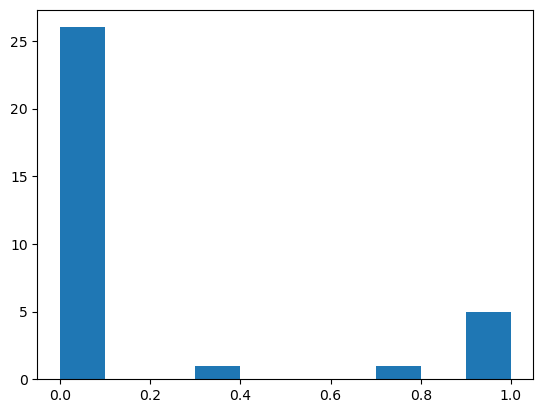

In [86]:
import matplotlib.pyplot as plt
file_list = os.listdir("/media/hc/0ef0b6ec-9072-46c4-b4cb-46308083eedb/home/hc/[NII-IDR] 楽天市場データ/sample/sample_csv")
path = os.path.join("/media/hc/0ef0b6ec-9072-46c4-b4cb-46308083eedb/home/hc/[NII-IDR] 楽天市場データ/sample/sample_csv",file_list[0])
dataset = feature_dataset(path=path)
plt.hist(dataset.data_frame[0])
plt.savefig("n1.png")

/media/hc/0ef0b6ec-9072-46c4-b4cb-46308083eedb/home/hc/[NII-IDR] 楽天市場データ/sample/sample_csv/sample_from_raw5.csv
25000


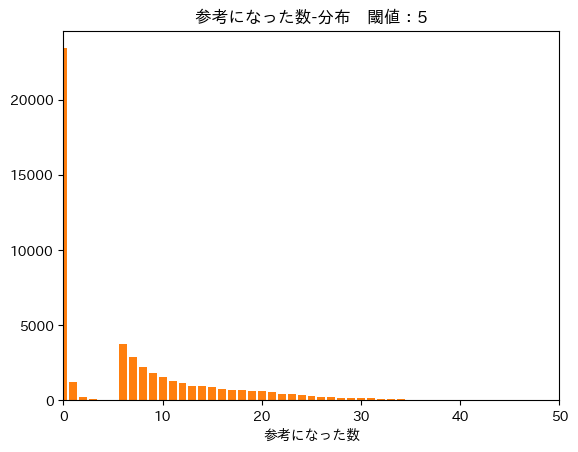

In [139]:
train_bar = tqdm(desc="train bar", total=32000//128, position=2, leave=True)

file_list = os.listdir("/media/hc/0ef0b6ec-9072-46c4-b4cb-46308083eedb/home/hc/[NII-IDR] 楽天市場データ/sample/sample_csv")
file_list = sorted(file_list,key=get_int)
path = os.path.join("/media/hc/0ef0b6ec-9072-46c4-b4cb-46308083eedb/home/hc/[NII-IDR] 楽天市場データ/sample/sample_csv",file_list[5])
print(path)
data = pd.read_csv(path)
yy = data['参考になった数'].to_numpy()
x, y = np.unique(yy,return_counts=True)
fig, ax = plt.subplots()
ax.bar(x,y)
print((yy>5).sum())
ax.set_xlabel("参考になった数")
ax.set_title("参考になった数-分布　閾値：5")
ax.set_xlim((0,50))
plt.bar(x,y)
plt.savefig("dis.png")

In [27]:

file_list = os.listdir("/media/hc/0ef0b6ec-9072-46c4-b4cb-46308083eedb/home/hc/[NII-IDR] 楽天市場データ/sample/sample_csv")

file_bar = tqdm(desc="file_bar", total=len(file_list), position=0)
epoch_bar = tqdm(desc="epoch bar", total=100, position=1)
train_bar = tqdm(desc="train bar", total=32000//128, position=2, leave=True)
val_bar = tqdm(desc="val bar", total=8000//128, position=2, leave=True)
test_bar = tqdm(desc="test_bar", total=10000//128, position=2, leave=True)
file_list = sorted(file_list,key=get_int)
record = {}
test_record = {}
for idx in range(len(file_list)):

    path = os.path.join("/media/hc/0ef0b6ec-9072-46c4-b4cb-46308083eedb/home/hc/[NII-IDR] 楽天市場データ/sample/sample_csv",file_list[idx])
    dataset = feature_dataset(path=path)

    file_bar.set_postfix(idx=idx)
    device = torch.device("cuda")
    model = MLP(input_dim=33,hidden_dim=8,out_dim=1).to(device)
    loss = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
    epoch_num = 100
    index = str(idx)
    record[index] = {'train':{'epoch':[],
                                 'loss':[],
                                 'acc':[]},
                         'val':{'epoch':[],
                                'loss':[],
                                'acc':[]}}
    test_record[index] = []
    for epoch in range(epoch_num):
        dataset.config('train')
        dataloader = torch.utils.data.DataLoader(dataset=dataset, shuffle=True, drop_last=True, batch_size=128)
        model.train()
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device).view(-1,1)
            pred_y = model(x)
            l = loss(pred_y, y)

            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            acc = compute_accuracy(pred_y, y)

            train_bar.set_postfix(acc=acc, loss=l.item())
            train_bar.update()

        record[index]['train']['epoch'].append(epoch)
        record[index]['train']['loss'].append(l.item())
        record[index]['train']['acc'].append(acc)

        dataset.config('val')
        dataloader = torch.utils.data.DataLoader(dataset=dataset, shuffle=True, drop_last=True, batch_size=128)
        model.eval()

        n_correct = 0
        n_sample = 0
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device).view(-1,1)
            pred_y = model(x)
            l = loss(pred_y, y)


            acc = compute_accuracy(pred_y, y)

            y_target = y.cpu()
            y_indice = (torch.sigmoid(pred_y) > 0.5).cpu().long()
            n_correct += torch.eq(y_target,y_indice).sum().item()
            n_sample += y.shape[0]
            acc_t = n_correct/n_sample * 100
            val_bar.set_postfix(acc=acc_t, loss=l.item(),correct=n_correct,sample=n_sample)
            val_bar.update()



        record[index]['val']['epoch'].append(epoch)
        record[index]['val']['loss'].append(l.item())
        record[index]['val']['acc'].append(acc)

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.set_postfix(epoch=epoch)
        epoch_bar.update()


    model.eval()
    dataset.config('test')
    dataloader = torch.utils.data.DataLoader(dataset=dataset, shuffle=True, drop_last=True, batch_size=128)
    n_sample = 0
    n_correct = 0
    with torch.no_grad():
        for i, (x,y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device).view(-1,1)
            pred_y = model(x)


            y_target = y.cpu()
            y_indice = (torch.sigmoid(pred_y) > 0.5).cpu().long()
            n_correct += torch.eq(y_target,y_indice).sum().item()
            n_sample += y.shape[0]
            acc_t = n_correct/n_sample * 100

            test_bar.set_postfix(acc=acc_t)
            test_bar.update()
    test_bar.n = 0
    file_bar.update()
    acc_test = n_correct/n_sample * 100
    test_record[index].append(acc_test)

    epoch_bar.n = 0


file_bar:   0%|          | 0/22 [00:00<?, ?it/s]

epoch bar:   0%|          | 0/100 [00:00<?, ?it/s]

train bar:   0%|          | 0/250 [00:00<?, ?it/s]

val bar:   0%|          | 0/62 [00:00<?, ?it/s]

test_bar:   0%|          | 0/78 [00:00<?, ?it/s]

In [32]:
import json
with open("test_repocrd.json", 'w') as fp:
    json.dump(test_record,fp)

In [30]:
record

{'0': {'train': {'epoch': [0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73,
    74,
    75,
    76,
    77,
    78,
    79,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    87,
    88,
    89,
    90,
    91,
    92,
    93,
    94,
    95,
    96,
    97,
    98,
    99],
   'loss': [0.6809112429618835,
    0.6447786092758179,
    0.6348752975463867,
    0.6252275109291077,
    0.6194548606872559,
    0.5928272008895874,
    0.6067405939102173,
    0.6002

In [29]:
# device = torch.device('cuda')
# model = MLP(input_dim=33,hidden_dim=8,out_dim=1).to(device)

# loss = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
# epoch_num = 100
# epoch_bar = tqdm(desc="epoch bar", total=epoch_num, position=0)
# train_bar = tqdm(desc="Train bar", total=len(dataloader), position=1)

# for epoch in range(epoch_num):
#     for i, (x, y) in enumerate(dataloader):
#         x = x.to(device)
#         y = y.to(device).view(-1,1)
#         pred_y = model(x)
#         l = loss(pred_y,y)

#         l.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         acc = compute_accuracy(pred_y, y)
#         train_bar.set_postfix(acc=acc, loss=l.item())
#         train_bar.update()

#     train_bar.n = 0

#     epoch_bar.update()


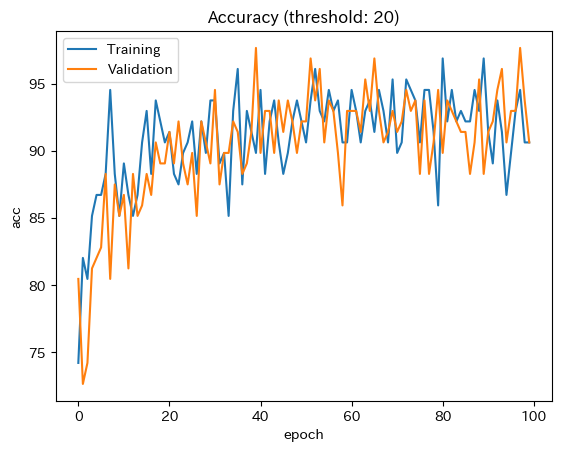

In [149]:
import json
import matplotlib.pyplot as plt
with open("repocrd.json", 'r') as fp:
    record = json.load(fp=fp)
fig, ax = plt.subplots()
ax.plot(record['20']['train']['epoch'],record['20']['train']['acc'], label="Training")
ax.plot(record['20']['val']['epoch'],record['20']['val']['acc'], label="Validation")
ax.legend(loc="upper left")
ax.set_ylabel("acc")
ax.set_xlabel("epoch")
ax.set_title("Accuracy (threshold: 20)")
plt.savefig("0.png")


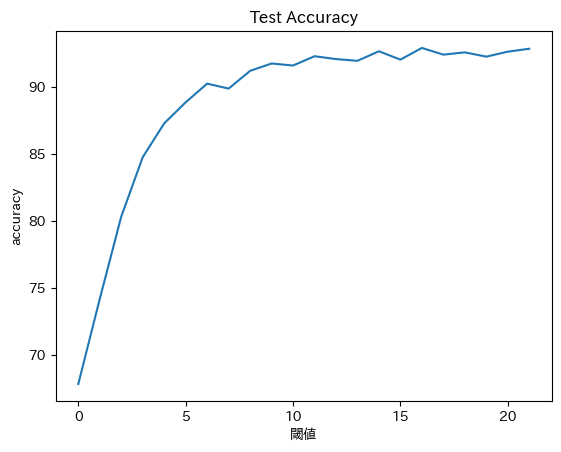

In [162]:
acc = [i[0] for i in list(test_record.values())]
epoches = list(range(22))
fig, ax = plt.subplots()
ax.plot(epoches,acc)
ax.set_title("Test Accuracy")
ax.set_xlabel("閾値")
ax.set_ylabel("accuracy")
plt.savefig("t.png")